# Pre-trained models benchmark

In this notebook you may find a benchmark with the available pretrained models from ultralytics, evaluted in the coco8 dataset in *.pt format taking into account Preprocess+Inference speed, FPS, mAP50-90 and mAP_S

In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from ultralytics import YOLO

%matplotlib inline

In [17]:
def get_flops_with_torch_profiler(model, imgsz=640):
    """Compute model FLOPs (thop alternative)."""
    #model = de_parallel(model) in case of pasing DDP model, it transforms it to a single GPU model
    p = next(model.parameters())
    stride = (max(int(model.stride.max()), 32) if hasattr(model, 'stride') else 32) * 2  # max stride
    im = torch.zeros((1, p.shape[1], stride, stride), device=p.device)  # input image in BCHW format
    with torch.profiler.profile(with_flops=True) as prof:
        model(im)
    flops = sum(x.flops for x in prof.key_averages()) / 1E9
    imgsz = imgsz if isinstance(imgsz, list) else [imgsz, imgsz]  # expand if int/float
    flops = flops * imgsz[0] / stride * imgsz[1] / stride  # 640x640 GFLOPs
    return flops

In [40]:
archs = ['yolov8n']#, 'yolov8s', 'yolov8m', 'yolov5nu', 'yolov5su', 'yolov5mu', 'yolov5n6u']
t_pre = []
t_infer = []
t_post = []
maps = []
params = []
flops = []

o_t_pre = []
o_t_infer = []
o_t_post = []
o_maps = []

r_t_pre = []
r_t_infer = []
r_t_post = []
r_maps = []

#maps_s = []
#save dir: metrics.save_dir

In [41]:
dataset = './../ultralytics/cfg/datasets/coco.yaml'
devices = 0

In [42]:
for arch in archs:
    
    # Register model
    model = YOLO('./../../models/'+arch+'.pt')
    # Evalute in validation dataset
    metrics = model.val(data=dataset, verbose=True, plots=False, save_json=True, cache=True, device=devices)

    # Get metrics in *.pt format
    t_pre.append(metrics.speed['preprocess'])
    t_infer.append(metrics.speed['inference'])
    t_post.append(metrics.speed['postprocess'])
    maps.append(metrics.box.map)
    params.append(model.info()[1])
    flops.append(get_flops_with_torch_profiler(model.model, imgsz=640)) # TODO adjust image size for P6 model.

    
    # Export to ONNX format
    filename = model.export(format='onnx', dynamic=False, half=False, int8=False, simplify=False, opset=None) #TODO: INVESTIGATE
    # Register and Evaluate exported model
    export = YOLO(filename, task=model.task)
    results = export.val(data=dataset, batch=1, plots=False, verbose=False, imgsz=model.overrides['imgsz'], device=devices)

    # Get metrics in *.onnx format
    o_t_pre.append(results.speed['preprocess'])
    o_t_infer.append(results.speed['inference'])
    o_t_post.append(results.speed['postprocess'])
    o_maps.append(results.box.map)
    

    # Export to TensorRT
    # TODO: condition, if file exists load it, else export
    filename = './../../models/'+arch+'.engine'
    if not os.path.isfile(filename):
        filename = model.export(format='engine', dynamic=False, half=False, int8=False, simplify=False, workspace=4, device=devices) #TODO: INVESTIGATE
    else:
        print('TensorRT model already exists, loading it ...')
    # Register and Evaluate exported model
    export = YOLO(filename, task=model.task)
    results = export.val(data=dataset, batch=1, plots=False, verbose=False, imgsz=model.overrides['imgsz'], device=devices)

    # Get metrics in *.engine format
    r_t_pre.append(results.speed['preprocess'])
    r_t_infer.append(results.speed['inference'])
    r_t_post.append(results.speed['postprocess'])
    r_maps.append(results.box.map)
    

Ultralytics YOLOv8.0.145 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24260MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients
val: Scanning /data-fast/127-data2/ierregue/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
val: Caching images (4.1GB True): 100%|██████████| 5000/5000 [00:03<00:00, 1541.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [00:56<00:00,  5.54it/s]
                   all       5000      36335      0.632      0.475      0.521      0.371
                person       5000      10777      0.753      0.673      0.745      0.514
               bicycle       5000        314      0.684      0.392      0.457      0.264
                   car       5000       1918      0.645      0.516      0.561      0.364
            motorcycle       5000        367      0.709       0.58      0.655  

loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=5.46s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=54.83s).
Accumulating evaluation results...
DONE (t=12.92s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val54
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients
STAGE:2023-08-07 10:41:29 246083:246083 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-08-07 10:41:29 246083:246083 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-07 10:41:29 246083:246083 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Ultralytics YOLOv8.0.145 🚀 Python-3.8.10 torch-2.0.1+cu117 CPU (AMD EPYC 7452 32-Core Processor)

PyTorch: starting from '../../models/yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.14.0 opset 17...


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 1.3s, saved as '../../models/yolov8n.onnx' (12.2 MB)

Export complete (3.7s)
Results saved to /home-net/ierregue/project/detector/models
Predict:         yolo predict task=detect model=../../models/yolov8n.onnx imgsz=640 
Validate:        yolo val task=detect model=../../models/yolov8n.onnx imgsz=640 data=None 
Visualize:       https://netron.app
Ultralytics YOLOv8.0.145 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24260MiB)
Loading ../../models/yolov8n.onnx for ONNX Runtime inference...
Forcing batch=1 square inference (1,3,640,640) for non-PyTorch models
val: Scanning /data-fast/127-data2/ierregue/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5000/5000 [15:54<00:00,  5.24it/s]
                   all       5000      36335      0.629      0.476      0.521       

loading annotations into memory...
Done (t=1.53s)
creating index...
index created!
Loading and preparing results...
DONE (t=4.99s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=57.45s).
Accumulating evaluation results...
DONE (t=10.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val55
Ultralytics YOLOv8.0.145 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24260MiB)
Loading ../../models/yolov8n.engine for TensorRT inference...


TensorRT model already exists, loading it ...
[08/07/2023-10:58:55] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[08/07/2023-10:58:55] [TRT] [I] Loaded engine size: 19 MiB
[08/07/2023-10:58:55] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +16, now: CPU 0, GPU 49 (MiB)
[08/07/2023-10:58:55] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +17, now: CPU 1, GPU 66 (MiB)
[08/07/2023-10:58:55] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


val: Scanning /data-fast/127-data2/ierregue/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5000/5000 [01:42<00:00, 48.65it/s]
                   all       5000      36335      0.629      0.476      0.521       0.37
Speed: 0.7ms preprocess, 1.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Saving /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val60/predictions.json...

Evaluating pycocotools mAP using /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val60/predictions.json and /data-fast/127-data2/ierregue/datasets/coco/annotations/instances_val2017.json...


loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Loading and preparing results...
DONE (t=6.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=56.80s).
Accumulating evaluation results...
DONE (t=10.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Results saved to /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val60


In [43]:
df = pd.DataFrame({
    'architecture': archs,
    'parameters': params,
    'FLOPs': flops,
    'preprocess': t_pre,
    'o_preprocess': o_t_pre,
    'r_preprocess': r_t_pre,
    'inference': t_infer,
    'o_inference': o_t_infer,
    'r_inference': r_t_infer,
    'postprocess': t_post,
    'o_postprocess': o_t_post,
    'r_postprocess': r_t_post,
    'mAP': maps,
    'o_mAP': o_maps,
    'r_mAP': r_maps,
})

# TODO: compute with sum?
df['FPS'] = 1000/df.inference
df['o_FPS'] = 1000/df.o_inference
df['r_FPS'] = 1000/df.r_inference

In [44]:
df

,architecture,parameters,FLOPs,preprocess,o_preprocess,r_preprocess,inference,o_inference,r_inference,postprocess,o_postprocess,r_postprocess,mAP,o_mAP,r_mAP,FPS,o_FPS,r_FPS
0,yolov8n,3151904,8.745132,0.107458,0.606359,0.726463,1.590211,152.478599,1.532936,1.488104,21.248587,1.897921,0.370955,0.370352,0.370471,628.847174,6.558297,652.343158


<Figure size 1200x1000 with 0 Axes>

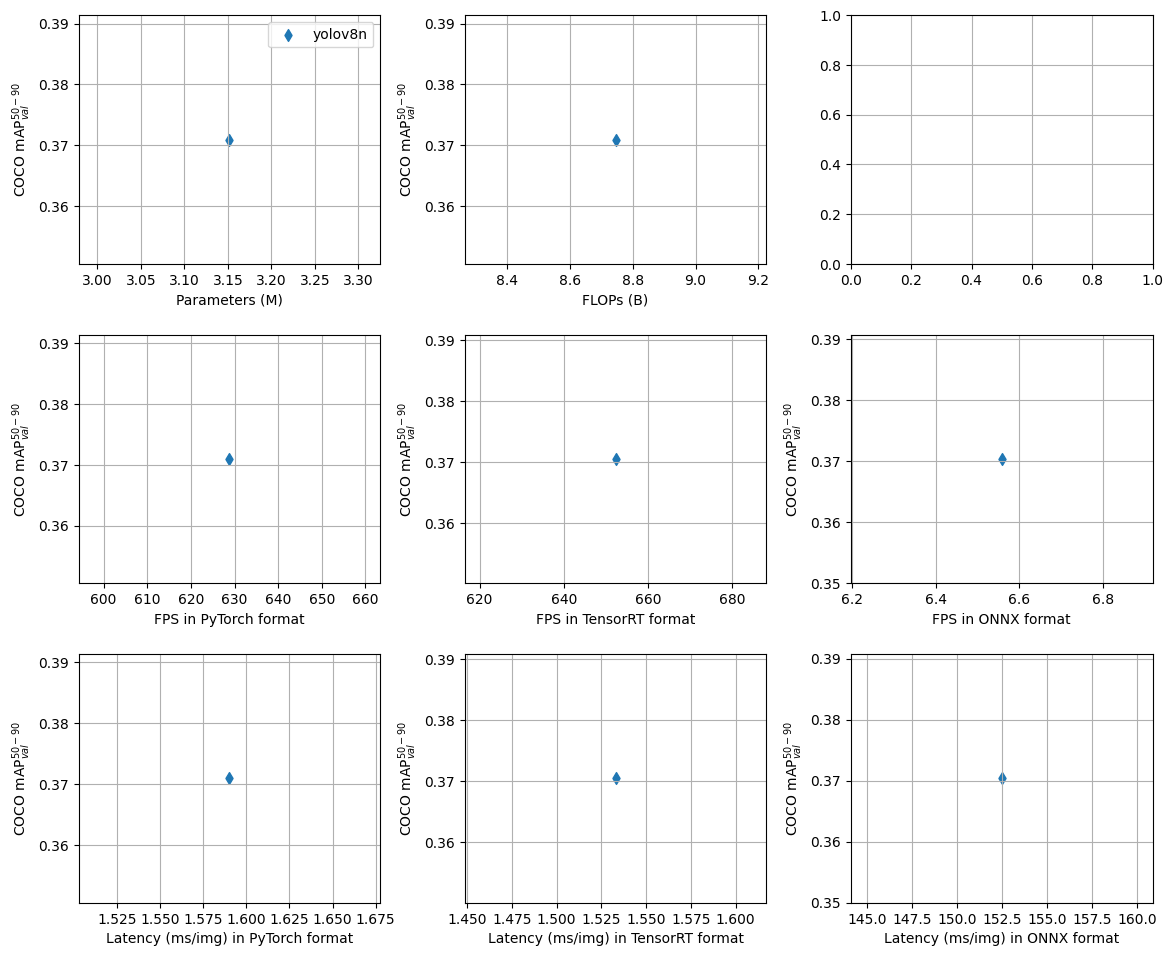

In [45]:
markers = ["d", "v", "s", "^", "*", 'x', 'h', 'p', '8', '<', '>']
plt.rcParams["figure.figsize"] = (12,10)
plt.rcParams['axes.grid'] = True

f = plt.figure()
f, axes = plt.subplots(nrows = 3, ncols = 3, sharex=False, sharey=False)
f.tight_layout(pad=3.0)

for index, row in df.iterrows():

    # ROW 0: Parameters, FLOPs, mAP_S
    axes[0][0].scatter(row.parameters/10**6, row.mAP, marker=markers[index], label=row.architecture)
    axes[0][0].set_xlabel('Parameters (M)')
    axes[0][0].set_ylabel(r'COCO mAP$^{50-90}_{val}$')

    axes[0][1].scatter(row.FLOPs, row.mAP, marker=markers[index])
    axes[0][1].set_xlabel('FLOPs (B)')
    axes[0][1].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
    

    # ROW1 FPS: 
    axes[1][0].scatter(row.FPS, row.mAP, marker=markers[index])
    axes[1][0].set_xlabel('FPS in PyTorch format')
    axes[1][0].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
    
    axes[1][1].scatter(row.r_FPS, row.r_mAP, marker=markers[index])
    axes[1][1].set_xlabel('FPS in TensorRT format')
    axes[1][1].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
    
    axes[1][2].scatter(row.o_FPS, row.o_mAP, marker=markers[index])
    axes[1][2].set_xlabel('FPS in ONNX format')
    axes[1][2].set_ylabel(r'COCO mAP$^{50-90}_{val}$')


    # ROW 2 Latency:
    axes[2][0].scatter(row.inference, row.mAP, marker=markers[index])
    axes[2][0].set_xlabel('Latency (ms/img) in PyTorch format')
    axes[2][0].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
    
    axes[2][1].scatter(row.r_inference, row.r_mAP, marker=markers[index])
    axes[2][1].set_xlabel('Latency (ms/img) in TensorRT format')
    axes[2][1].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
    
    axes[2][2].scatter(row.o_inference, row.o_mAP, marker=markers[index])
    axes[2][2].set_xlabel('Latency (ms/img) in ONNX format')
    axes[2][2].set_ylabel(r'COCO mAP$^{50-90}_{val}$')

axes[0][0].legend()
plt.show()

In [24]:
# mAP_s
# Investigate ONNX/TensorRT exportation arguments 
# Latency
# Read json to map_s

In [47]:
metrics.save_dir

PosixPath('/home-net/ierregue/project/detector/small-fast-detector/runs/detect/val54')

In [25]:
metrics.confusion_matrix.conf

0.25

In [26]:
metrics.box.map

0.4816107113950196

In [27]:
metrics.box

ultralytics.utils.metrics.Metric object with attributes:

all_ap: array([[    0.80881,     0.79487,     0.78138,     0.75666,     0.70609,     0.65245,     0.52836,       0.453,     0.34559,    0.070584],
       [    0.42722,     0.41122,     0.41122,     0.37693,     0.37693,     0.37693,     0.37693,     0.37693,    0.016432,           0],
       [    0.42556,     0.41247,      0.3627,     0.34198,     0.30054,     0.27131,     0.24236,     0.18858,    0.055582,    0.010218],
       [    0.92833,     0.92833,        0.88,        0.88,        0.88,        0.88,     0.69862,     0.33359,     0.33359,           0],
       [      0.995,     0.92357,     0.92357,     0.92357,     0.92357,     0.92357,      0.7415,      0.7415,     0.61434,     0.36516],
       [    0.69947,     0.69947,     0.69947,     0.69947,     0.69947,     0.69947,     0.69947,     0.69947,     0.53381,    0.051691],
       [      0.755,       0.755,       0.755,       0.755,     0.53333,     0.53333,     0.53333,  

In [ ]:
model

In [ ]:
def eval_json(data_dir, predictions_dir):
    """Evaluates YOLO output in JSON format and returns performance statistics."""
    anno_json = data_dir
    pred_json = predictions_dir+'/predictions.json'  # predictions
    try:  # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb
        from pycocotools.coco import COCO  # noqa
        from pycocotools.cocoeval import COCOeval  # noqa

        anno = COCO(str(anno_json))  # init annotations api
        pred = anno.loadRes(str(pred_json))  # init predictions api (must pass string, not Path)
        eval = COCOeval(anno, pred, 'bbox')
        if self.is_coco:
            eval.params.imgIds = [int(Path(x).stem) for x in self.dataloader.dataset.im_files]  # images to eval
        eval.evaluate()
        eval.accumulate()
        eval.summarize()
    except Exception as e:
        print(f'pycocotools unable to run: {e}')

In [ ]:
annType = ['bbox']      #specify type here
prefix = 'instances'
print('Running demo for *%s* results.'%(annType))
dataDir='./../../datasets/coco/'
dataType='val2017'
annFile = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)

In [ ]:
eval_json(annFile, './../../small-fast-detector/runs/detect/val19') #predictions_dir=str(results.save_dir)

In [ ]:
s